In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from skimage.feature import hog, local_binary_pattern
from sklearn.svm import LinearSVC
from helpers import *

### Reading handwritten images from file and store it with it's lable 
for male y =0 and for female y =1

In [2]:
data = read_data("data_set")


0start ..
1start ..


e:\DonyaAll\CMP2023-Y3\Second Sem\Neural\project\helpers.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(data)


### spliting the data with randomness and visualizing the data 

In [3]:
data_train, data_test, y_train, y_test = train_test_split(
    data[:, 0], data[:, 1], test_size=0.20, random_state=42)


### Resize images to be 128*64 for HOG feature extraction

In [4]:
data_train_resized = resized_images(data=data_train)
data_test_resized = resized_images(data=data_test)


In [5]:
def apply_hog(data):
    featureVecs = []
    outputImgs = []
    for img in data:
        featureVecHog, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),
                                       cells_per_block=(3, 3), visualize=True, multichannel=False)
        featureVecs.append(featureVecHog)
        outputImgs.append(hog_image)
    return featureVecs, outputImgs


### LBP feature extraction using original images

In [31]:
def describe(numPoints, radius, image):
    # compute the Local Binary Pattern representation
    # of the image, and then use the LBP representation
    # to build the histogram of patterns
    lbp = local_binary_pattern(image, numPoints,
                               radius, method="uniform")        
    return lbp.ravel()

In [27]:
def apply_LBP(data, numPoints, Radius):
    featureVecs = []
    i=0
    for img in data:
        res= describe(numPoints, Radius, img)
        featureVecs.append(res)
        print(i, len(res))
        i+=1
    return featureVecs


In [18]:
print(data_train_resized[0].shape)

(128, 64)


In [19]:
training_HOG, traning_imgs = apply_hog(data_train_resized)


In [20]:
testing_HOG, testing_imgs = apply_hog(data_test_resized)

In [32]:
training_LBP = apply_LBP(data=data_train, numPoints=8, Radius=1)
testing_LBP = apply_LBP(data=data_test, numPoints=8, Radius=1)


0 4888080
1 9342384
2 6858316
3 7202592
4 9141460
5 8213280
6 5757696
7 6761664
8 6211008
9 5524896
10 11328660
11 7906375
12 9593136
13 6340864
14 5927600
15 6922264
16 9340884
17 7398576
18 6553248
19 5375088
20 5867040
21 9724080
22 5806672
23 8677956
24 5521600
25 9904448
26 6676800
27 5829488
28 5791072
29 8632345
30 9463440
31 8801744
32 9136160
33 5673216
34 6075963
35 5046912
36 9170928
37 9653032
38 5878544
39 9507456
40 5365440
41 6013920
42 7124544
43 5280496


In [8]:
print(training_HOG[0].shape[0])

6804


In [13]:
all_training_feats = np.zeros((data_train.shape[0],training_HOG[0].shape[0]+training_LBP[0].shape[0] ))
all_testing_feats = np.zeros((data_test.shape[0], testing_HOG[0].shape[0]+testing_LBP[0].shape[0]))

In [14]:
all_training_feats[:,0:training_HOG[0].shape[0]]= training_HOG
all_training_feats[:,training_HOG[0].shape[0]:(training_HOG[0].shape[0]+training_LBP[0].shape[0])]= training_LBP
all_testing_feats[:,0:testing_HOG[0].shape[0]]= testing_HOG
all_testing_feats[:,testing_HOG[0].shape[0]:(testing_HOG[0].shape[0]+testing_LBP[0].shape[0])]= testing_LBP

In [15]:
print(len(training_HOG))
print(training_HOG[0].shape)
print(len(training_LBP))

print(training_LBP[0].shape)
print(all_training_feats.shape)

290
(6804,)
290
(10,)
(290, 6814)


In [29]:
def train_svm(data, y_train):
    # train a Linear SVM on the data
    model = LinearSVC(C=100.0, random_state=42)
    y_train =y_train.astype('int')
    model.fit(data, y_train)
    return model


In [17]:
svm_m_all = train_svm(data=all_training_feats, y_train=y_train)
train_predicted_all = svm_m_all.predict(all_training_feats)
print(f"Training accuracy is %0.2f"%(np.sum(train_predicted_all == y_train)/len(y_train) * 100))
test_predicted_all = svm_m_all.predict(all_testing_feats)
print(f"Testing accuracy is %0.2f"%(np.sum(test_predicted_all == y_test)/len(y_test) * 100))

Training accuracy is 100.00
Testing accuracy is 69.86


In [10]:
svm_m_HOG = train_svm(data=training_HOG, y_train=y_train)
train_predicted_HOG = svm_m_HOG.predict(training_HOG)
print(f"Training accuracy is %0.2f"%(np.sum(train_predicted_HOG == y_train)/len(y_train) * 100))
test_predicted_HOG = svm_m_HOG.predict(testing_HOG)
print(f"Testing accuracy is %0.2f"%(np.sum(test_predicted_HOG == y_test)/len(y_test) * 100))


Training accuracy is 100.00
Testing accuracy is 67.12


In [30]:
svm_m_LBP = train_svm(data=training_LBP, y_train=y_train)
train_predicted_LBP = svm_m_LBP.predict(training_LBP)
print(f"Training accuracy is %0.2f"%(np.sum(train_predicted_LBP == y_train)/len(y_train) * 100))
test_predicted_LBP = svm_m_LBP.predict(testing_LBP)
print(f"Testing accuracy is %0.2f"%(np.sum(test_predicted_LBP == y_test)/len(y_test) * 100))


Training accuracy is 63.45
Testing accuracy is 65.75


c:\Users\Donia\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


c:\Users\Donia\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

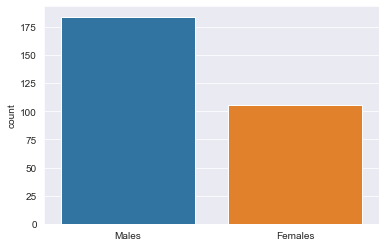

In [20]:
lables = []
for i in y_train:
    if(i == 0):
        lables.append("Males")
    else:
        lables.append("Females")
sns.set_style('darkgrid')
sns.countplot(lables)


In [21]:
image_gray = cv2.cvtColor(data_train[2], cv2.COLOR_BGR2GRAY)
thresh = cv2.adaptiveThreshold(image_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 11, 2)


error: OpenCV(4.5.4) d:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x27ffac8e::Set<1,-1,-1>,struct cv::impl::A0x27ffac8e::Set<0,2,5>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


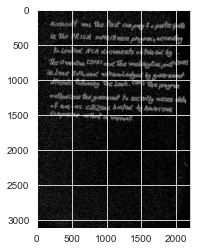

In [ ]:
plt.imshow(thresh, 'gray', vmin=0, vmax=255)
plt.show()
